# Homework 2: Dijkstra and Ising

# Part 1 - Find your way in Paris

For many of you this is the first year in Paris, one of the most cosmopolitan city in the world. During this homework we will help you building your home-made navigator using the Dijkstra algorithm (see [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)).

Moreover you will challenge yourself on how to create nice and readable plots using Python.

## Data loading

By running the cells below, you will download all the required data. You can also download them manually and put them in the same folder as the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import bisect

from scipy.optimize import curve_fit
from tqdm.auto import tqdm

## Map data preparation

Run the cells below to download the data about the map of Paris.

In [2]:
# Run this code to create a list of the coordinates of the different arrondissements of Paris
arrondis = pd.read_csv("arrondissements-millesimes0.csv", delimiter=";")
arrondis = arrondis[arrondis.Commune.str.contains("PARIS")]
shapes = arrondis.geo_shape
coords = []
arr_names = arrondis.nom_com.values
for shape in shapes:
    temp=json.loads(shape)
    coords.append(np.array(temp['coordinates'])[0,...])

`coords` is a list of the points making up the perimeter of each arrondissement in Paris: `coords[0]` is a $M \times 2$ matrix with $M$ the number of points. By using `plt.plot(coords[0][:,0],coords[0][:,1])` you can plot the whole arrondissement. The important variables here are`coords` and `arr_names`, i.e. the coordinates and the name of the arrondissement.

### Data preparation

Run the two cells below to (i) download the data and (ii) create the networks.  Note that the run time of the second cell is longer and might take one minute.

* Each node of the network is labeled by a unique code and represents a single line station of the Paris transportation network (metro, rer, tram or bus) as of 2018. For example the metro station *Jussieu* is associated to two codes (282 and 283) one for the metro line 7 and the other for the metro line 10.

* The dictionary `net` contains the information about the neighbors of a given node. To find the list of nodes that you can reach from the node `i` you may use `net[i]`

* The time (in seconds) taken to travel from the station i to the neighoring station j is given in the nested dictionary `durations`. `durations[i][j]` represents either the time taken by the public transport (bus, metro...) to connect two consecutive stations or the estimated walking time needed for the change. Note that the network is directed as `durations[i][j]` can be different from `durations[j][i]`.

In [3]:
net_names = pd.read_csv("network_nodes.csv", delimiter=";")
combined = pd.read_csv("network_combined.csv", delimiter=";")
walk = pd.read_csv("network_walk.csv", delimiter=";")

def search_station(src_string):
    return net_names[net_names.name.str.contains(src_string, case=False)]
def station_name(id):
    return net_names[net_names.stop_I == id].name.values[0]
def station_position(id):
    line = net_names[net_names.stop_I == id]
    return line.lon.values[0], line.lat.values[0]

walk_symm = walk.copy()
walk_symm.from_stop_I = walk.to_stop_I
walk_symm.to_stop_I = walk.from_stop_I
walk = walk.append(walk_symm)
walk = walk.sort_values(by='from_stop_I')
walk = walk.reset_index(drop=True)
final_net = combined.merge(walk, on=['from_stop_I','to_stop_I'], how='outer')
final_net = final_net[["from_stop_I",	"to_stop_I","duration_avg","d_walk"]]
final_duration = np.fmin(final_net.duration_avg,final_net.d_walk)
final_net["duration"] = final_duration
max_idx = max(np.max(final_net["from_stop_I"].values),np.max(final_net["to_stop_I"].values))
min_idx = min(np.min(final_net["from_stop_I"].values),np.min(final_net["to_stop_I"].values))
net ={}
for i in range(min_idx, max_idx+1):
    net[i] = []
durations = {}
for id, g in final_net.groupby('from_stop_I'):
    net[id].extend(list(g["to_stop_I"].values))
    durations[id] = {}
    for _,line in g.iterrows():
      #durations[id][line.to_stop_I] = line.duration  #old line of code, bug due to change in version
      durations[id][int(line.to_stop_I)] = line.duration

C:\Users\Adrie\AppData\Local\Temp\ipykernel_6428\3798319327.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  walk = walk.append(walk_symm)


## Implementation of the Dijkstra algorithm

Complete the following code to implement the Dijkstra algorithm for this network 

In [4]:
def dijkstra(net, durations, source):
    
    # dur_src[i] should contain (at the end) the duration (in seconds) that it takes to go from 'source' to 'i'
    dur_src = {}
    
    # Previous_node[i] should contain (at the end) the node preceeding 'i' in the minimal-distance path between 'source' and 'i'
    previous_node = {}
    
    # List of unvisited nodes and their distance to source through visited nodes in order of increasing distance
    unvisited = [source] + [k for k in net if k != source]
    unvisited_dist = [0] + [np.infty] * (len(net)-1)
    
    # This for-loop initializes correctly dur_src and previous_node
    for k in net.keys():
        dur_src[k] = np.infty
        previous_node[k] = None
    
    # Naturally 'source' has duration '0' from itself
    dur_src[source] = 0
    
    # The source has previous_node -1
    previous_node[source] = -1
    
    while len(unvisited) > 0:
        
        current_node = unvisited.pop(0)
        unvisited_dist.pop(0)
        
        for neighbor in net[current_node]:
            if dur_src[current_node] + durations[current_node][neighbor] < dur_src[neighbor]:
                
                # Locate neighbor in unvisited: we first use bisect on unvisited_dist to reduce the scope of possible indices
                index_left = bisect.bisect_left(unvisited_dist, dur_src[neighbor])
                index_right = bisect.bisect_right(unvisited_dist, dur_src[neighbor])
                old_index = unvisited.index(neighbor, index_left, index_right)
                
                # Remove it from unvisited and unvisited_dist
                unvisited.pop(old_index)
                unvisited_dist.pop(old_index)
                
                # Update the distance and previous node
                dur_src[neighbor] = dur_src[current_node] + durations[current_node][neighbor]
                previous_node[neighbor] = current_node                
                
                # Locate the new index and insert neighbor in its updated position
                new_index = bisect.bisect(unvisited_dist, dur_src[neighbor])
                unvisited.insert(new_index, neighbor)
                unvisited_dist.insert(new_index, dur_src[neighbor])
    
    return dur_src, previous_node

We give you an hint for such implementation. Use the same trick we used to construct the clusters in the Wolff algorithm. In order to explore the network more efficiently it is better to pop the elements in 'border' starting from the oldest one (e.g. the one that we added first during the exploration). To do this simply use the function .pop(0) instead of .pop(). Namely:

```
border = [source]
  while(len(border)>0):
    next_node = border.pop(0)
```

Use [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)! It provides you a nice pseudocode to start understanding the algorithm:

    function Dijkstra(Graph, source):
       
       for each vertex v in Graph.Vertices:
           dist[v] ← INFINITY
           prev[v] ← UNDEFINED
           add v to Q
       dist[source] ← 0
       
       while Q is not empty:
          u ← vertex in Q with min dist[u]
          remove u from Q
          
          for each neighbor v of u still in Q:
              alt ← dist[u] + Graph.Edges(u, v)
              if alt < dist[v]:
                  dist[v] ← alt
                  prev[v] ← u

      return dist[], prev[]


## Question 1

After the Friday lesson you have been invited to a party held at 358 rue de Pyrénées. The closest metro station is *Pyrénées* (with code 146). From 24 rue Lhomond the closest metro station is *Place Monge - Jardin des Plantes* (with code 42). Compute the minimal duration of the trip to reach the party.


In [6]:
map_42 = dijkstra(net, durations, 42)

In [7]:
map_42[0][146]

1102.3563318145657

## Question 2

Reconstruct the full path listing all the intermediate stations and the time (in minutes) taken to reach them. The final result should look like:
```
Station: 42 Time: 0
Station: yyyy Time: zzzz
(omissis)
Station: 146 Time: xxxx
```

In [8]:
current_station = 146

station_list = [146]
time_list = []

while current_station != 42:
    prev_station = map_42[1][current_station]
    time_list.append(durations[prev_station][current_station])
    current_station = prev_station
    station_list.append(current_station)

time_list.append(0)
time_list.reverse()
station_list.reverse()
time_list = np.cumsum(time_list)

for station, time in zip(station_list, time_list):
    print("Station: {}\tTime: {:.6}\t".format(station, time) + station_name(station))

Station: 42	Time: 0.0	Place Monge (Jardin des Plantes)
Station: 282	Time: 85.303	Jussieu
Station: 75	Time: 195.909	Sully-Morland
Station: 190	Time: 268.182	Pont Marie (Cité des Arts)
Station: 335	Time: 356.97	Châtelet
Station: 334	Time: 579.97	Châtelet
Station: 269	Time: 639.97	Hôtel de Ville
Station: 149	Time: 705.125	Rambuteau
Station: 404	Time: 783.025	Arts-et-Métiers
Station: 26502	Time: 869.516	République
Station: 332	Time: 945.268	Goncourt (Hôpital Saint-Louis)
Station: 417	Time: 1011.71	Belleville
Station: 146	Time: 1102.36	Pyrénées


## Question 3
* Represent your results on the map of Paris and indicate the name of each station in the path.

* To do this we provide two functions:
  1.   A function 'station_name(id)' that, given the code of the station, returns its name:
    ```
    station_name(42)
    ```
  2.   A function 'station_position(id)' that, given the code of the station, returns its GPS coordinates as a tuple i.e. (x,y):
  ```
    station_position(42)
    ```
* We provide also a code below that generates an empty map. All the data needed to do so have been downloaded in section 'Data loading'. Modify the code in order to answer the question.

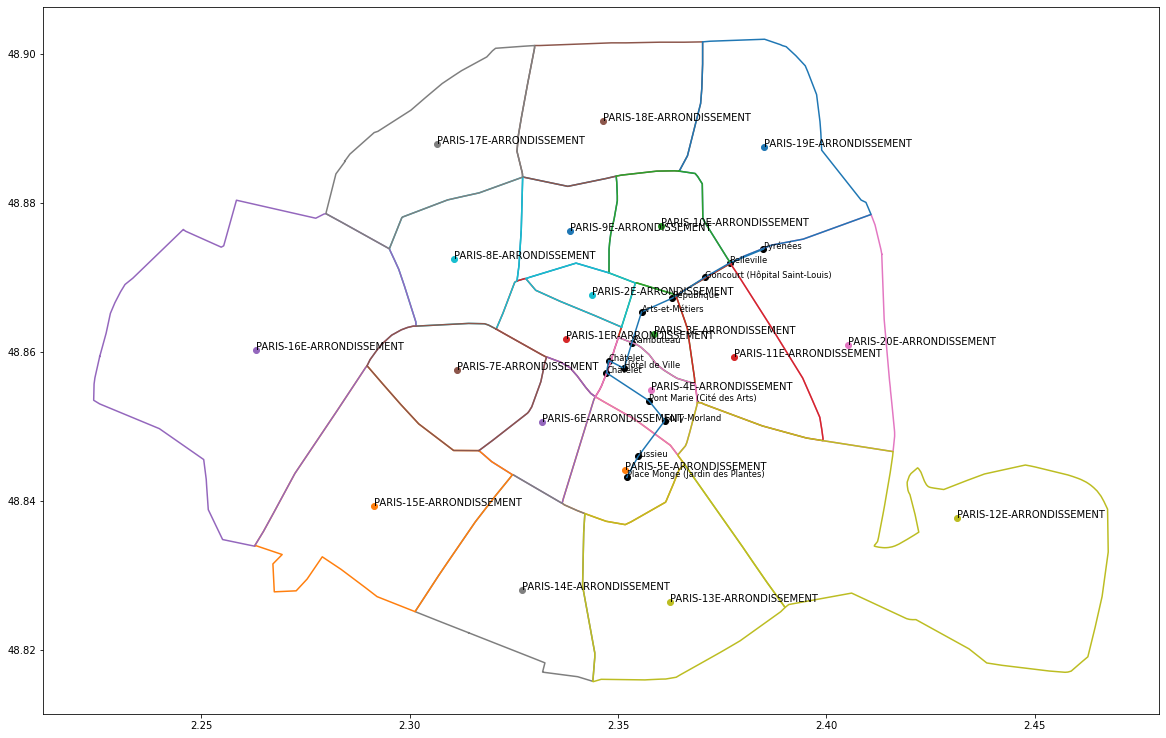

In [9]:
# The variables coords and arr_names have been generated in the 'Data loading/Map data preparation' section
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
    # Plots the perimeter
    plt.plot(coord[:,0], coord[:,1])
    # Centroid of the arrondissement 
    x_avg = np.mean(coord[:,0])
    y_avg = np.mean(coord[:,1])
    # Adds a text and a bullet at the centroid of the arr.
    plt.text(x_avg, y_avg, arr_names[idx])
    plt.scatter(x_avg, y_avg)

x_list = []
y_list = []
for station in station_list:
    x, y = station_position(station)
    x_list.append(x)
    y_list.append(y)
    plt.text(x, y, station_name(station), size='small')
    plt.scatter(x, y, c='k')
plt.plot(x_list, y_list)
print()

## Question 4

Unfortunately a big social protest is taking place in Jussieu and the metro stations with codes 282 and 283 are closed. Find an alternative itinerary to reach the party. Provide its duration and map.

### Hint
Since Jussieu is closed for the whole day, the duration of the connections to and from Jussieu become one day longer (i.e. 86400 seconds). In order to avoid Jussieu modify the nested-dictionary 'durations' and add at the appropriate spots this time delay.


Station: 42	Time: 0.0	Place Monge (Jardin des Plantes)
Station: 13185	Time: 45.0	MONGE
Station: 13183	Time: 175.0	CARDINAL LEMOINE
Station: 377	Time: 207.0	Cardinal-Lemoine
Station: 195	Time: 283.279	Maubert-Mutualité
Station: 345	Time: 346.07	Cluny-La Sorbonne
Station: 46	Time: 408.163	Odéon
Station: 226	Time: 438.163	Odéon
Station: 120	Time: 511.363	Saint-Michel
Station: 343	Time: 571.896	Cité
Station: 333	Time: 658.029	Châtelet
Station: 334	Time: 800.029	Châtelet
Station: 269	Time: 860.029	Hôtel de Ville
Station: 149	Time: 925.185	Rambuteau
Station: 404	Time: 1003.08	Arts-et-Métiers
Station: 26502	Time: 1089.58	République
Station: 332	Time: 1165.33	Goncourt (Hôpital Saint-Louis)
Station: 417	Time: 1231.77	Belleville
Station: 146	Time: 1322.42	Pyrénées



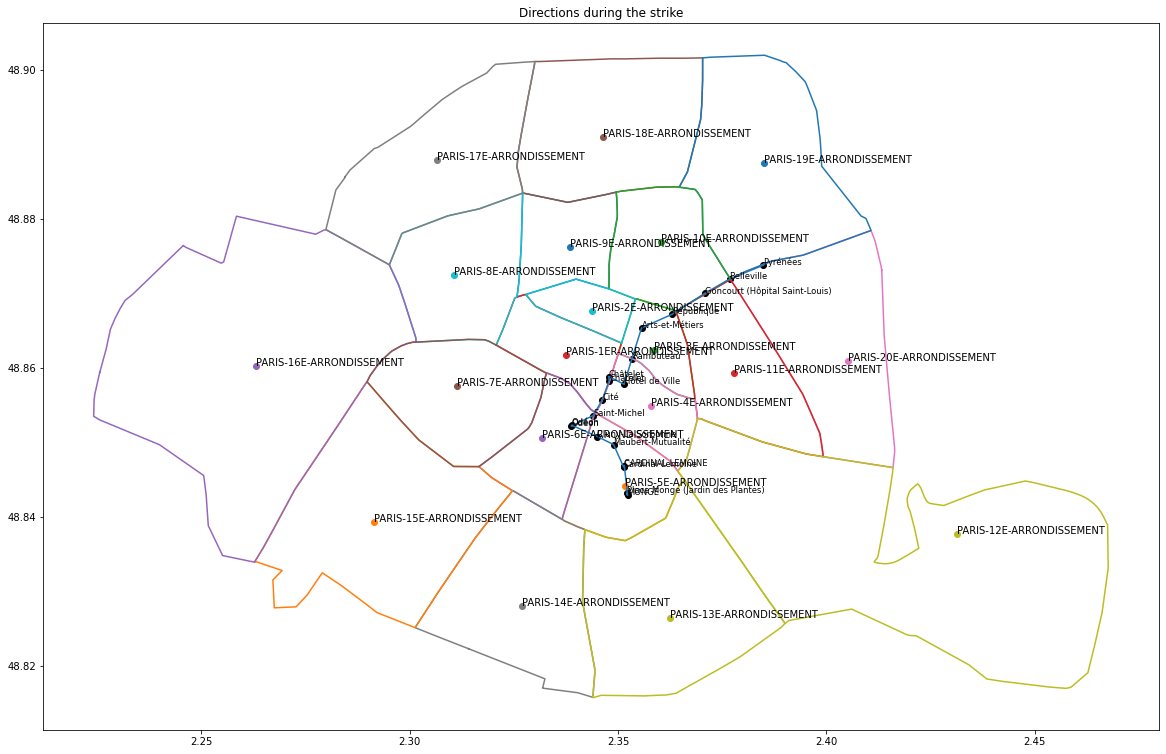

In [10]:
# Modify paths towards 282 and 283
for station in durations:
    for closed_station in [282, 283]:
        if closed_station in durations[station]:
            durations[station][closed_station] += 86400

# Modify paths out of 282 and 283 (take care to not double count the delay on the connections between 282 and 283)
for closed_station in [282, 283]:
    for station in durations[closed_station]:
        if station not in [282, 283]:
            durations[closed_station][station] += 86400

# Dijkstra's algorithm on the modified network
map_42_strike = dijkstra(net, durations, 42)

current_station = 146

station_list = [146]
time_list = []

while current_station != 42:
    prev_station = map_42_strike[1][current_station]
    time_list.append(durations[prev_station][current_station])
    current_station = prev_station
    station_list.append(current_station)

time_list.append(0)
time_list.reverse()
station_list.reverse()
time_list = np.cumsum(time_list)

for station, time in zip(station_list, time_list):
    print("Station: {}\tTime: {:.6}\t".format(station, time) + station_name(station))

# The variables coords and arr_names have been generated in the 'Data loading/Map data preparation' section
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
    # Plots the perimeter
    plt.plot(coord[:,0], coord[:,1])
    # Centroid of the arrondissement 
    x_avg = np.mean(coord[:,0])
    y_avg = np.mean(coord[:,1])
    # Adds a text and a bullet at the centroid of the arr.
    plt.text(x_avg, y_avg, arr_names[idx])
    plt.scatter(x_avg, y_avg)

x_list = []
y_list = []
for station in station_list:
    x, y = station_position(station)
    x_list.append(x)
    y_list.append(y)
    plt.text(x, y, station_name(station), size='small')
    plt.scatter(x, y, c='k')
plt.plot(x_list, y_list)
plt.title("Directions during the strike")
print()

# Part 2 - Further exploration of the Ising model

In this second part, you will be interested in the two-dimensional Ising model.
As a reminder, the Ising model describes a set of spins sitting on the sites
of a given lattice. You will consider the **periodic** two-dimensional square
lattice with $N = L \times L$ sites. The spin sitting on the site $j$ is described by
a variable $\sigma_j = \pm 1$. The energy for
a given configuration $\{ \sigma \}$ of spins is

$$
E(\{\sigma\}) = -J\sum_{\langle ij \rangle} \sigma_i \sigma_j
$$

where $\langle i j \rangle$ indicates that $i$ and $j$ are
nearest-neighbors on the lattice. In the following, you will consider the
ferromagnetic case $J>0$ and use $J=1$ as the unit of energy.
The Ising model has a phase transition at the critical temperature

$$
T_c = \frac{2}{\ln(1+\sqrt{2})} = 2.269185\ldots
$$

## The Glauber algorithm

During the lecture, you have studied three different Monte Carlo algorithms for the Ising model. Here, you will investigate one more: the Glauber algorithm.
Just like the heat-bath it is also a rejection-free
algorithm. The algorithm follows these steps:

1. Pick a random site $i$ on the lattice

2. Flip the spin $\sigma_i$ on site $i$ to $-\sigma_i$ with probability:

   $$
    P^\mathrm{flip}_i = \frac{1}{1 + \exp(\beta \, 2 J \sigma_i h_i)}
   $$
   
   where $h_i$ is the molecular field on the site $i$:
   
   $$
   h_i = \sum_{j \, \in \, \text{neighbors of $i$}} \sigma_j
   $$
   
3. Go back to step 1.

### Question 5

Prove that the Glauber algorithm leads to a sampling of the configurations that follows the Boltzmann distribution.

#### Answer 5

Let us show that the detailed balance is statisfied. For any two configurations $\sigma$ and $\sigma'$ with at least two different spins, the transition probability is 0 both ways so the detailed balance is statisfied. Therefore, let $\sigma$ and $\sigma'$ be two configurations different only on spin $i$. The transition probabilities are then given by:

\begin{align}
p_{\sigma \to \sigma'} &= \frac{1}{N(1 + \exp(\beta \, 2 J \sigma_i h_i))} \\
p_{\sigma' \to \sigma} &= \frac{1}{N(1 + \exp(-\beta \, 2 J \sigma_i h_i))}
\end{align}

with $\sigma_i$ the value of spin $i$ in the configuration $\sigma$. The stationnary probability following the Boltzmann distribution is given by:

\begin{align}
\pi_\sigma &= \frac 1 Z \exp(-\beta(-h_i \sigma_i + H_{\neq i})) \\
\pi_{\sigma'} &= \frac 1 Z \exp(-\beta(h_i \sigma_i + H_{\neq i}))
\end{align}

with $H_{\neq i}$ the part of the energy that does not depend on $\sigma_i$ and is therefore identical for both $\sigma$ and $\sigma'$. To summarize:

\begin{align}
p_{\sigma \to \sigma'} \pi_\sigma &= \frac{\exp(-\beta H_{\neq i}))}{NZ} \frac{\exp(\beta h_i \sigma_i)}{1 + \exp(\beta \, 2 J \sigma_i h_i))} \\
&= \frac{\exp(-\beta H_{\neq i}))}{NZ} \frac{2}{\cosh(\beta h_i \sigma_i)} \\
p_{\sigma' \to \sigma} \pi_{\sigma'} &= \frac{\exp(-\beta H_{\neq i}))}{NZ} \frac{\exp(-\beta h_i \sigma_i)}{1 + \exp(-\beta \, 2 J \sigma_i h_i))} \\
&= \frac{\exp(-\beta H_{\neq i}))}{NZ} \frac{2}{\cosh(\beta h_i \sigma_i)}
\end{align}

**And so the detailed balance is satisfied.**

### Question 6

Implement the Glauber algorithm and compare your results to those
  obtained with the Wolff algorithm.
  More specifically, use both algorithms to compute: the absolute value of the magnetization,
  the specific heat, the energy and the susceptibility as a function of temperature.
  Use a $6 \times 6$ lattice and 10 temperatures in the range $[0.5, 4.0]$.
  
  The function that implements the Glauber algorithm can have the signature
  ```python
def glauber(config, T)
    # your code
  ```
  where `config` is a spin configuration to be modified by the Glauber algorithm and `T`
  is the temperature. Just like for the heat bath, let the function apply a total of
  $N = L \times L$ proposal moves.
  
  When running
  the Wolff algorithm, use the implementation below. It is an improved version of the algorithm
  that we have used in the lecture that runs a bit faster:

  ```python
def wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                
        config[i,j] *= -1
   ```

#### Answer 6

_A code as well as 4 plots showing a comparison between the algorithms are expected._

In [11]:
def glauber(config, T):
    
    L = config.shape[0]
    
    for _ in range(L**2):
        
        i, j = np.random.randint(L, size=2)
        h_eff = config[(i+1)%L,j] + config[(i-1)%L,j] + config[i,(j+1)%L] + config[i,(j-1)%L]
        p_flip = 1 / (1 + np.exp(2 * h_eff * config[i,j] / T))
        
        if np.random.random() < p_flip:
            config[i,j] = -config[i,j]


def wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                
        config[i,j] *= -1

In [12]:
def compute_energy(config):
    pair_sum = 0
    for i in range(L):
        for j in range(L):
            pair_sum += config[i,j] * config[(i+1)%L,j] + config[i,j] * config[i,(j+1)%L]
    return -pair_sum
    
    
def compute_magnetization(config):
    return np.sum(config)


def monte_carlo(L, T, monte_carlo_move, n_steps):
        
    # generate starting configuration
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    
    # tables where observables are stored
    magnetizations = np.zeros(n_steps)
    energies = np.zeros(n_steps)
    
    # Monte Carlo
    for i in range(n_steps):
    
        # make Monte Carlo moves
        monte_carlo_move(spin_configuration, T)
            
        # store energy and magnetization
        energies[i] = compute_energy(spin_configuration)
        magnetizations[i] = compute_magnetization(spin_configuration)
           
    # get average and error bar
    en = np.average(energies) / L**2
    mag = np.average(np.abs(magnetizations)) / L**2
    cv = np.var(energies) / T**2 / L**2
    chi = np.var(np.abs(magnetizations)) / T / L**2

    return en, mag, cv, chi

In [13]:
L = 6
n_steps = 10000
T_list = np.linspace(0.5, 4.0, 10)

glauber_res = [[],[],[],[]]
wolff_res = [[],[],[],[]]

# loop over temperatures
for T in tqdm(T_list):
    
    res = monte_carlo(L, T, glauber, n_steps)
    for k in range(4):
        glauber_res[k].append(res[k])
    
    res = monte_carlo(L, T, wolff, n_steps)
    for k in range(4):
        wolff_res[k].append(res[k])

  0%|          | 0/10 [00:00<?, ?it/s]

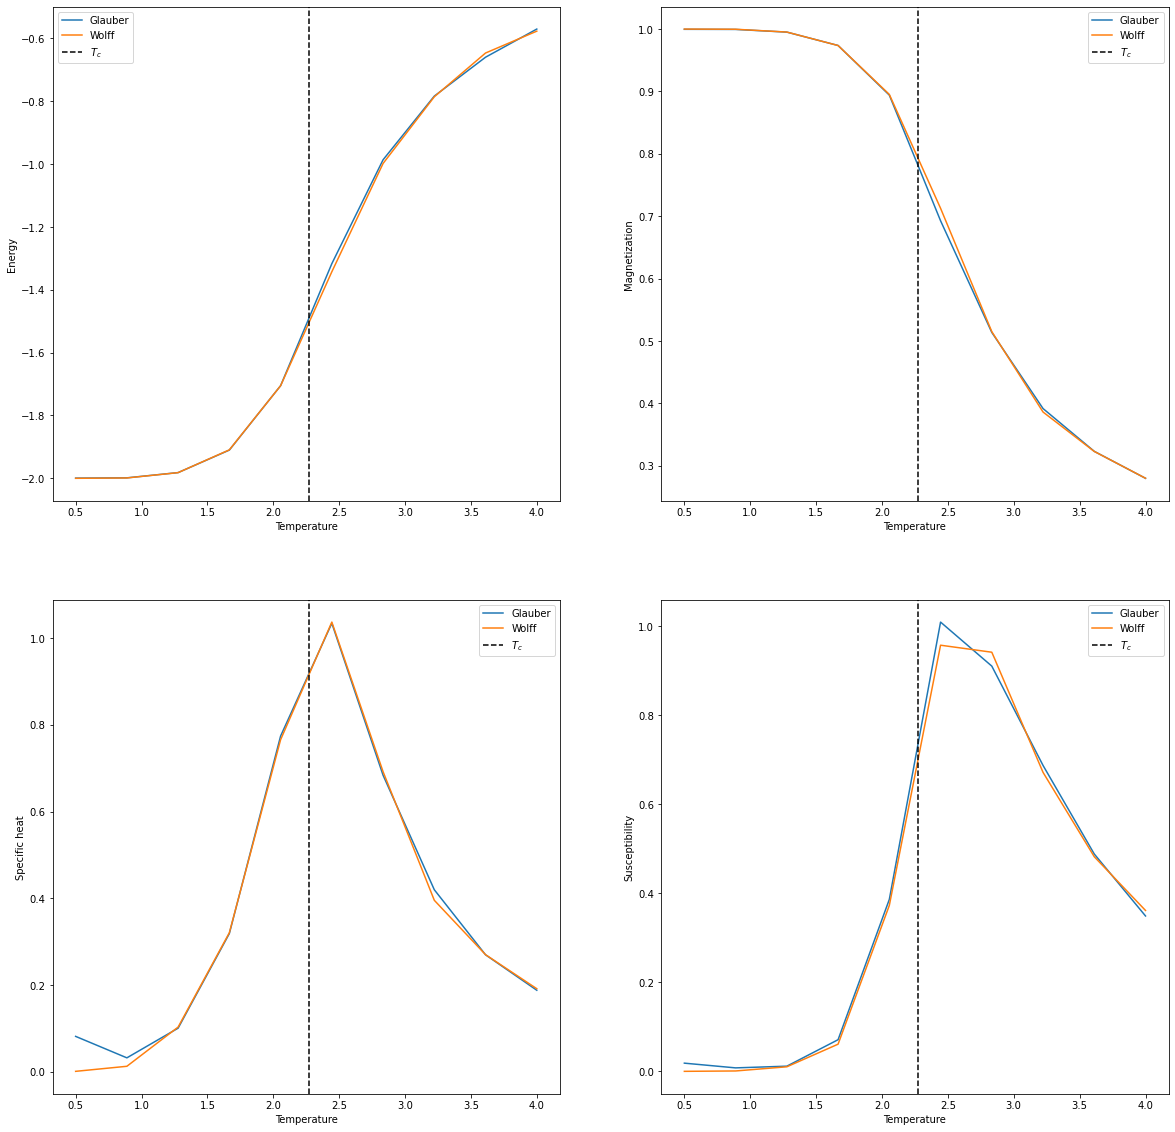

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))

observables = ["Energy", "Magnetization", "Specific heat", "Susceptibility"]

for k in range(4):
    ax[k//2, k%2].plot(T_list, glauber_res[k], label="Glauber")
    ax[k//2, k%2].plot(T_list, wolff_res[k], label="Wolff")
    ax[k//2, k%2].set_xlabel("Temperature")
    ax[k//2, k%2].set_ylabel(observables[k])
    ax[k//2, k%2].axvline(2.27, c='k', ls='--', label="$T_c$")
    ax[k//2, k%2].legend()

## Cluster size histogram

In this section, you will investigate the distribution of cluster sizes in the Wolff cluster
algorithm. In particular, you will study what are the cluster sizes that are sampled
in different regimes of the Ising model: low temperature, high temperature and at the critical temperature $T_c$.

### Question 7

Make a small modification to the `wolff` function given above so that it returns
  the size of the cluster that was flipped. Then, create histograms that display the distribution
  of cluster sizes that are flipped during the Monte Carlo sampling. Compute these histograms
  for 3 temperatures: $T = 0.9 T_c, T_c, 1.1 T_c$ for a system of size $32 \times 32$.
  Discuss the results.

#### Answer 7

_A code using your modified `wolff` function is expected, together with 3 histogram plots and a discussion of the results._

In [15]:
def modified_wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    cluster_size = 0
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                
        config[i,j] *= -1
        cluster_size += 1
    
    return cluster_size

In [16]:
L = 32
n_steps = 10000

T_c = 2 / np.log(1 + 2**0.5)
T_list = [0.9*T_c, T_c, 1.1*T_c]

cluster_sizes = np.zeros((3, n_steps))

for i,T in enumerate(T_list):
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    for j in range(n_steps):
        cluster_sizes[i,j] = modified_wolff(spin_configuration, T)

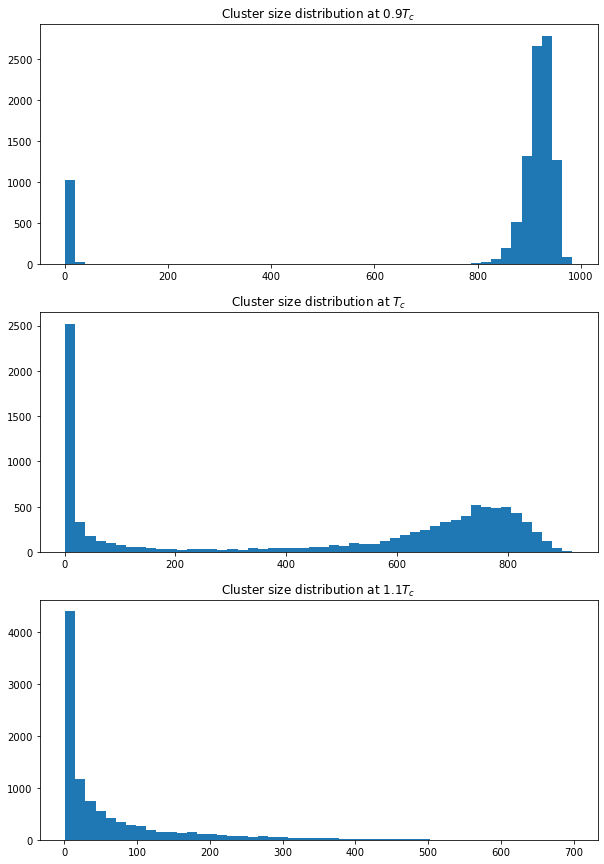

In [17]:
fig, ax = plt.subplots(3, figsize=(10,15))
labels = ["$0.9T_c$", "$T_c$", "$1.1T_c$"]

for k in range(3):
    ax[k].hist(cluster_sizes[k], bins=50)
    ax[k].set_title("Cluster size distribution at " + labels[k])

- Below $T_c$, almost all spins are aligned and so either the initial spin has a common sign in which case the cluster can spread a lot, or it has an uncommon sign in which case it stops quickly. This leads to clusters being either very large (around 900, that is almost all spins) or very small.
- Above $T_c$, the spins are randomly oriented and so the spread of the cluster is handicapped by the fact that half the spins have the opposite sign as the initial one, and the cluster size histogram vanishes quickly.
- At $T_c$, there is a sort of mix between the two. The scale invariance makes it so that clusters have a finite probability of spreading a lot, and a finite probability of stopping quickly.

## Spin-spin correlations

In this last section, you will compute and discuss the spin-spin correlation function.
It is defined by the following average

$$
  C(r) = \langle \sigma_i \; \sigma_{i+r} \rangle
$$

This function measures how the spin at site $i$ and the spin at site $i+r$ are correlated.
In the following, you will focus on the case where $r$ is a vector along the horizontal
axis. In other words, the site $i$ and the site $i+r$ are on the same row. The correlation
function $C(r)$ does not depend on $i$ because of the translational symmetry of the lattice.
On an infinite lattice and not too far from the critical temperature, it can be shown that the correlation function has the following
behavior at large $r$:
  
$$
 C(r) \sim A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
$$

where $\xi$ is the correlation length and $A, S$ are constants. Onsager has shown that
the critical exponent $\eta = 1/4$.

### Question 8

Write a function that computes the correlation function $C(r)$ using the Wolff cluster
  Monte Carlo algorithm on a $32 \times 32$ lattice.
  Compute $C(r)$ at two temperatures: $T = 0.8 T_c$ and $T = 1.2 T_c$. Discuss the qualitative differences
  between these results (using plots of $C(r)$ in both cases).

#### Answer 8

_A code as well as two plots with a discussion of the results are expected._

In [18]:
def correlation_monte_carlo(L, T, n_steps):
        
    # generate starting configuration
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    
    # correlation lengths at each monte-carlo step
    correlations = np.zeros((n_steps, L//2))
    
    # Monte Carlo
    for k in range(n_steps):
    
        # make Monte Carlo moves
        wolff(spin_configuration, T)
            
        # compute correlations
        for r in range(L//2):
            correlations[k,r] = np.mean(spin_configuration * np.roll(spin_configuration, r, axis=1))
           
    return np.mean(correlations, axis=0)

In [19]:
L = 32
n_steps = 5000

T_c = 2 / np.log(1 + 2**0.5)

below_corr = correlation_monte_carlo(L, 0.8*T_c, n_steps)
above_corr = correlation_monte_carlo(L, 1.2*T_c, n_steps)

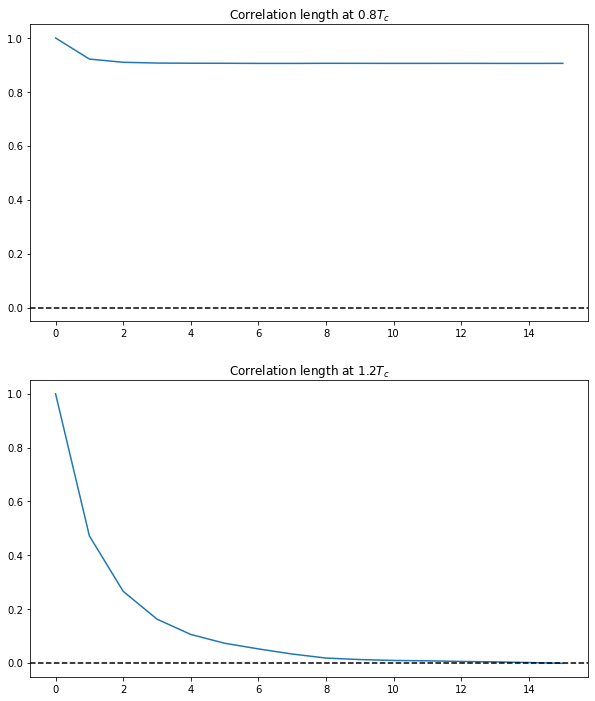

In [20]:
fig, ax = plt.subplots(2, figsize=(10,12))

ax[0].plot(below_corr)
ax[0].set_title("Correlation length at $0.8T_c$")
ax[0].axhline(0, c='k', ls='--')

ax[1].plot(above_corr)
ax[1].set_title("Correlation length at $1.2T_c$")
ax[1].axhline(0, c='k', ls='--')

print()

Below $T_c$, the phase is ordered and so the correlation remains close to $1$ regardless of distance. On the other hand, above $T_c$ the phase is disordered and so the correlation decays quickly.

### Question 9

Compute the correlation function $C(r)$ for 10 temperatures in the range
  $[T_c - 0.3, T_c + 0.3]$. Fit these correlation functions with a function of the form
  
  $$
    f_\mathrm{fit}(r) = A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
  $$

  where $A$, $S$, $\eta$ and $\xi$ are fitting parameters. Note that even though we know that $\eta = 1/4$
  from the Onsager solution, we will not assume we know that value and you should use $\eta$ as one of the
  fitting parameters. Create plots that show $C(r)$ and its fits.
  
#### Hints
  
  - Because we work with finite lattices with periodic boundary conditions, be careful
    to only use *half* of the data in $C(r)$.
    
  - The fitting function is in principle only valid for large $r$. In practice, you can
    just **ignore the first point** (at $r=0$) of the data in the fit.
      
  - You can use `scipy.optimize` to do the fits. Here is an example of how it works:
  
    ```python
    import scipy.optimize
    
    # fit function
    def fit_function(x, a, b, c):
      return # some function of (x,a,b,c)

    # data obtained by Monte Carlo
    x_values = ...
    y_values = ...
    
    # do the fit
    a, b, c = scipy.optimize.curve_fit(fit_function, x_values, y_values, bounds=[0,20])[0]
    
    ```
   
    where we have specified that the fit should only consider values for $a,b,c$ in $[0,20]$.

#### Answer 9

_A code together with 10 plots is expected._


In [30]:
L = 32
n_steps = 20000

T_c = 2 / np.log(1 + 2**0.5)
T_list = np.linspace(T_c - 0.3, T_c + 0.3, 10)
correlations_list = np.zeros((10, L//2))

for k,T in enumerate(T_list):
    correlations_list[k] = correlation_monte_carlo(L, T, n_steps)

In [31]:
def fit_function(r, A, S, eta, xi):
    return A * np.exp(-r/xi) / (r/xi)**eta + S

fit_parameters = np.zeros((10, 4))

r_list = np.array(range(1, L//2))

for k in range(10):
    fit_parameters[k] = curve_fit(fit_function, r_list, correlations_list[k][1:])[0]

C:\Users\Adrie\AppData\Local\Temp\ipykernel_6428\3567852937.py:2: RuntimeWarning: invalid value encountered in power
  return A * np.exp(-r/xi) / (r/xi)**eta + S
C:\Users\Adrie\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


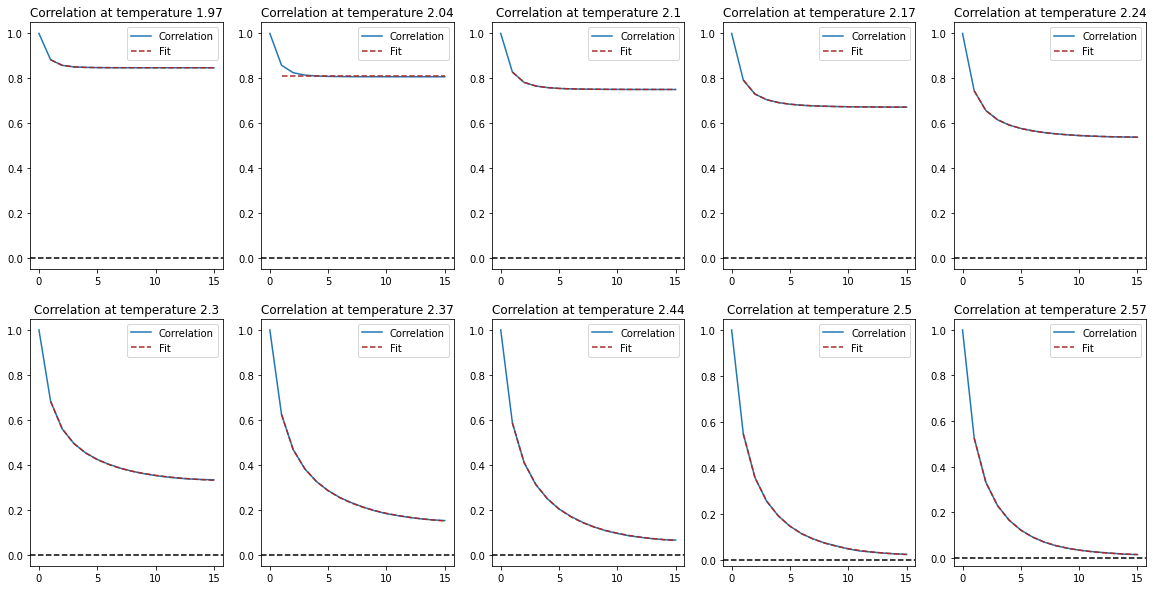

In [36]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))

for k in range(10):
    ax[k//5,k%5].plot(correlations_list[k], label='Correlation')
    ax[k//5,k%5].plot(r_list, fit_function(r_list, *fit_parameters[k]), c='brown', ls='--', label='Fit')
    ax[k//5,k%5].set_title("Correlation at temperature {:.3}".format(T_list[k]))
    ax[k//5,k%5].axhline(0, c='k', ls='--')
    ax[k//5,k%5].legend()

 ### Question 10
 
Discuss the behavior of the fitting parameters $\xi, \eta, S$ in connection with their physical meaning.

#### Answer 10

_A discussion of the results is expected. You may want to generate additional plots to support your discussion._

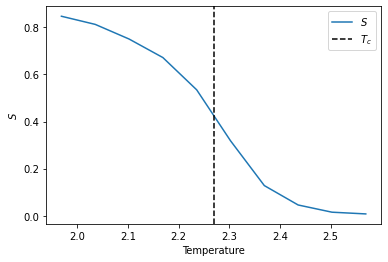

In [37]:
plt.plot(T_list, fit_parameters[:,1], label="$S$")
plt.xlabel("Temperature")
plt.ylabel("$S$")
plt.axvline(T_c, c='k', ls='--', label="$T_c$")
plt.legend()
print()

$S$ is the value of correlations at infinite length. As expected, it is close to $1$ in the ferromagnetic phase and vanishes in the paramagnetic phase.

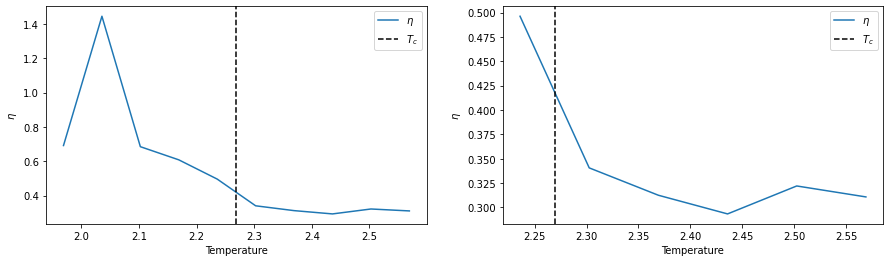

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

ax[0].plot(T_list, fit_parameters[:,2], label=r"$\eta$")
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel(r"$\eta$")
ax[0].axvline(T_c, c='k', ls='--', label="$T_c$")
ax[0].legend()

ax[1].plot(T_list[4:], fit_parameters[:,2][4:], label=r"$\eta$")
ax[1].set_xlabel("Temperature")
ax[1].set_ylabel(r"$\eta$")
ax[1].axvline(T_c, c='k', ls='--', label="$T_c$")
ax[1].legend()
print()

This one is a little less obvious, it should be $1/4$ but it is not so clear on the plot. With a bit of faith and a little zooming to the right we can still see that above the critical temperature our $\eta$ gets somwhat close to $1/4$. Maybe we can blame finite size ¯\\_(ツ)_/¯

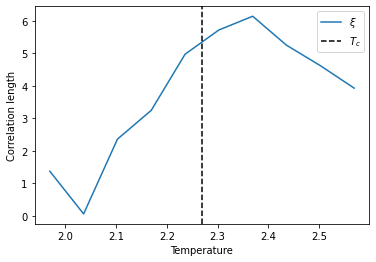

In [35]:
plt.plot(T_list, fit_parameters[:,3], label=r"$\xi$")
plt.xlabel("Temperature")
plt.ylabel("Correlation length")
plt.axvline(T_c, c='k', ls='--', label="$T_c$")
plt.legend()
print()

As expected, the correlation length is maximum near the critical temperature, where it would become infinite for infinite lattice size.